In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from numba import jit
import math
import re
import csv

import random
import seaborn as sns
import copy
import networkx as nx
import warnings

warnings.filterwarnings('ignore')

import time

In [5]:
@jit
def power_law_random_nu(gamma):
    #np.random.seed(seed)
    r = np.random.uniform()
    r1 = r**(1/(gamma-1))
    return r1


@jit(nopython=True)
def weighted_random(w, n):
    #np.random.seed(seed)
    cumsum = np.cumsum(w)
    rdm_unif = np.random.rand(n)
    return np.searchsorted(cumsum, rdm_unif)


@jit
def model(m, gamma, rho, gam, N, ini_nei_l, ini_act, finite_grow):
    
    # m        : [int] 新加入的结点带来的边的个数，一般也是网络的最小度
    # gamma    : [float] 结点(以及边)活跃间隔幂律分布的幂指数
    # rho, gam : [float] 调节已存在的结点连接新边的概率，也可以调节聚合网络的平均度，rho为网络规模的影响(全局的)，gam为结点度的影响(局部影响)。
    # N        : [int] 网络新增规模，同时也是演化时间
    # ini_nei_l: [nd.array] 初识时刻网络结构(邻居列表)
    # ini_act  : [nd.array] 初始时刻网络中结点的活跃概率列表
    # finite_grow: [False or int] if False 每个时间步都有新结点加入网络使网络生长, if int(>len(ini_nei_l)) 则网络达到固定规模后不再生长。
    
    # **Return = {
    #'snapshot' : [int] 取值t=[0,N], 此时返回t时刻时序网络的snapshot(邻接矩阵), 取值为 0时即返回初始网络结构
    #'agg_net'  : [int] 取值t=[0,N], 此时返回截至到t时刻结束聚合网络的邻接矩阵, 取值为 0时即返回初始网络结构
    #'node_act' : [int] 取值range(0, n+N), 其中n=len(ini_nei_l)为初识时刻网络中结点总数, 返回该结点的活跃时间序列
    #'link_act' : [tuple] tuple=(i,j)其中i,j应为聚合网络中相邻的结点，先后顺序无关，返回该边的活跃时间序列。}
    
    initial_nei_list = ini_nei_l ## t=0时网络结构
    initial_activity_list = ini_act ## t=0时各个结点的活跃概率，从分布p(a)中抽样得到
    #np.random.seed(seed)
    #snapshots = [initial_nei_list]
    file = open( "snapshots.txt", 'w')
    file.write(str(initial_nei_list))
    file.write('\n')
    
    file_n = open( "active_node.txt", 'w')

    #这两行代码没什么意义，更改变量名，相同指针
    final_nei_list = copy.deepcopy(initial_nei_list)
    final_activity_list = copy.deepcopy(initial_activity_list)
    
    for t in range(N):

        degree_list_at_t = np.array([len(i) for i in final_nei_list]) # t时间步(开始时)的网络度序列
        snap_nei_l = [set() for _ in range(len(final_nei_list))]
        
        r = np.random.random(len(final_activity_list))
        active_node = np.where(final_activity_list > r)[0] # t时间步活跃结点的列表
        active_node_degree = degree_list_at_t[active_node] # 活跃结点的度列表
        explore_prob = rho * active_node_degree**(-gam) / (t+1) # 活跃结点去连接新边的概率
        
        file_n.write(str(list(active_node)))
        file_n.write('\n')
        
        r1 = np.random.random(len(active_node))
        active_node_explore = active_node[np.where(explore_prob > r1)] # 活跃的结点中连接出新边的结点列表  active_node[np.where(explore_prob > r1)[0]]
        
        if active_node_explore.size:
            # 对active_node_explore中的结点，求其邻居集合的补集
            counter_nei = [list(set(range(len(final_nei_list))) - set(final_nei_list[active_node_explore[no]]) - set([active_node_explore[no]])) for no in range(active_node_explore.size)]
            
            for node, conter_nl in zip(active_node_explore, counter_nei):
                if len(conter_nl) > 0:
                    explore_p = degree_list_at_t[conter_nl] / sum(degree_list_at_t[conter_nl])
                    chosen_n = conter_nl[weighted_random(explore_p, 1)[0]]
                    
                    final_nei_list[node].append(chosen_n)
                    final_nei_list[chosen_n].append(node)
                    
                    snap_nei_l[node].add(chosen_n)
                    snap_nei_l[chosen_n].add(node)
        
        for node in list(set(active_node)-set(active_node_explore)):
            for nb in final_nei_list[node]:
                if nb in active_node:
                    snap_nei_l[node].add(nb)
                    snap_nei_l[nb].add(node)
        snap_nei_l = [list(item) for item in snap_nei_l]
        
        if (finite_grow > 0 and len(final_nei_list) < finite_grow) or finite_grow == 0:
        # 新结点加入，网络生长
            new_prob = degree_list_at_t / sum(degree_list_at_t)
            new_nl = []
            for _ in range(m):
                new_nodel = weighted_random(new_prob, 1)
                new_nl.append(new_nodel[0])
                new_prob[new_nodel[0]] = 0
                new_prob = new_prob / sum(new_prob)


            for new_n in new_nl:
                final_nei_list[new_n].append(len(final_nei_list))
                snap_nei_l[new_n].append(len(final_nei_list))

            final_nei_list.append(new_nl)
            snap_nei_l.append(new_nl)
            final_activity_list.append(power_law_random_nu(gamma))
        
        #snapshots.append(snap_nei_l)
        file.write(str(snap_nei_l))
        file.write('\n')
        for k in active_node:
            final_activity_list[k] = power_law_random_nu(gamma)
    

    file.close()
    file_n.close()
    
    
    return np.array(final_nei_list)

In [66]:
class GDAM:
    def __init__(self, n, m, gamma, rho, gam):
        self.n = n
        self.m = m
        self.gamma = gamma
        self.rho = rho
        self.gam = gam
        self.ini_nei_l = [list(set(range(n))-set([i])) for i in range(n)]
        self.ini_act = [power_law_random_nu(gamma) for i in range(n)]
    
    def evo(self, N, finite_grow):
        nl = model(self.m, self.gamma, self.rho, self.gam, N, self.ini_nei_l, self.ini_act, finite_grow)
        if finite_grow:
            total_n = finite_grow
        else:
            total_n = self.n + N
        total_e = int(sum([len(item) for item in nl]) / 2)
        print('Temporal network has been generated: Step -- {}, Nodes -- {}, Edges -- {}'.format(N, total_n, total_e))
        return nl
    
    
    def read_snapshot_file(self):
        file = open("snapshots.txt", 'r')
        X = file.readlines()#直接每行读取
        n=len(X)
        #print(n)
        for i in range(n):
            X[i] = X[i].strip()#去除后面的换行元素
            X[i] = X[i].split("],")#去除列表的[]符号
            ans = []
            for m in X[i]:
                h1 = m.strip().strip("[]").split(",")
                if h1 == ['']:
                    ans.append([])
                else:
                    ans.append(list(map(int, h1)))
            X[i] = ans
        return X
    
    def transform_nl_to_adj(self, nei_l):
        n = len(nei_l)
        adj = np.array([[0]*n for _ in range(n)])
        for i in range(n):
            for j in nei_l[i]:
                adj[i][j] = 1
        return adj
   
    def snapshot(self, num):
        snapshots = self.read_snapshot_file()
        snapshot_adj = self.transform_nl_to_adj(snapshots[num])
        return snapshot_adj
    
    def plot_CCDF(self, l):
        degree_l = l #[len(i) for i in nl]
        a_count_dict = dict(Counter(degree_l))
        a_count_dict_sorted =dict(sorted(a_count_dict.items(),key=lambda x:x[0]))

        x = a_count_dict_sorted.keys()
        y = [i/len(degree_l) for i in a_count_dict_sorted.values()]
        y_sum = sum(y)

        y_survive = []
        minus = 0
        for i in range(len(y)):
            y_sum = y_sum - minus
            y_survive.append(y_sum)
            minus = y[i]
        #x_set.append(list(x))
        #y_dict.append(dict(zip(x,y_survive)))
        fig = plt.figure(figsize =(6, 6))
        plt.loglog(x,y_survive, 'ro-')
        plt.xlabel('elements')
        plt.ylabel('Complementary cumulative distribution')
        plt.show
    
    def get_edge_t(self, i, j):
        snapshots = self.read_snapshot_file()
        active_l = [t for t in range(len(snapshots)) if len(snapshots[t]) > i and j in snapshots[t][i] ]
        return active_l
    
    def read_activenode_file(self):
        file = open("active_node.txt", 'r')
        X = file.readlines()
        #X
        n=len(X)
        for i in range(n):
            X[i] = X[i].strip()
            X[i] = X[i].strip("[]")
            X[i] = X[i].split(",")
            if X[i] == ['']:
                X[i] = []
            else:
                X[i] = list(map(int, X[i]))
        return X
    
    def get_activenode_t(self, i):
        active_node = self.read_activenode_file()
        active_l = [t for t in range(len(active_node)) if i in active_node[t]]
        return active_l

    
    def visualize_graph(self, nl):
        if len(nl.shape) > 1:
            adj = nl
        else:
            adj = self.transform_nl_to_adj(nl)
        G = nx.from_numpy_array(adj)
        dig = dict(nx.degree(G,weight='Weight')) # degree of network
        d = np.array(list(dig.values()))

        # pos=nx.spring_layout(G,iterations=200,k=2) # positions for all nodes
        pos= nx.kamada_kawai_layout(G) #nx.circular_layout(G,scale=1) # positions for all nodes
        # k = Optimal distance between nodes (default = 1/sqrt(n)), 
        # iterations = Number of iterations of spring-force relaxation

        plt.figure(figsize=(13,13)) #Control figure size
        nodes = nx.draw_networkx_nodes(G, pos=pos
                                       ,node_size = d*100+6
                                       ,node_color= d*10+6
                                       ,cmap=plt.cm.Greens
                                       ,edgecolors='#007317'
                                       ,alpha=0.75)
        edges = nx.draw_networkx_edges(G, pos=pos
                                       ,edge_color='#969696'
                                       ,alpha=0.5
                                       ,width=1.0)
        plt.axis("off")
        plt.title('Network visualization');


## Network generation

### 1. aggragred static network

Temporal network has been generated: Step -- 30000, Nodes -- 30, Edges -- 81


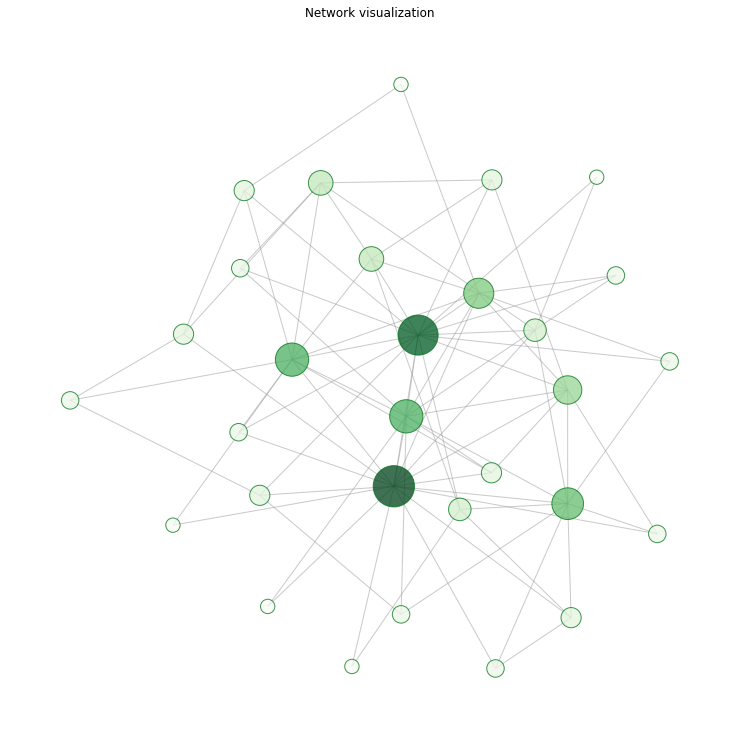

In [56]:
net = GDAM(5, 2, 2.2, 1., 0.7)
nl = net.evo(30000, 30)
net.visualize_graph(nl)

Temporal network has been generated: Step -- 56, Nodes -- 61, Edges -- 135


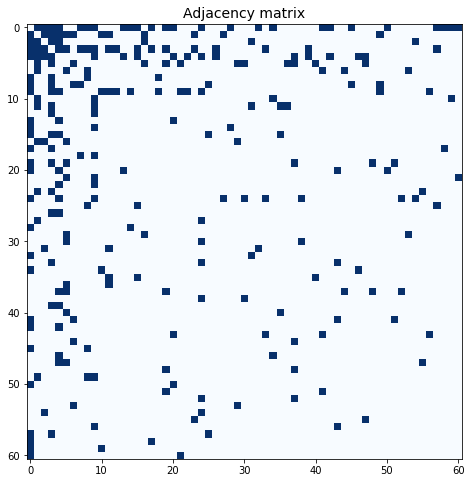

In [67]:
nl = net.evo(56, 0)
A = net.transform_nl_to_adj(nl)
plt.figure(1, figsize=(8, 8))# control figure size
plt.imshow(A,
           cmap="Blues",# color mapa
           interpolation="none"
           )
plt.title('Adjacency matrix', fontsize=14);

Temporal network has been generated: Step -- 1000, Nodes -- 1005, Edges -- 2134


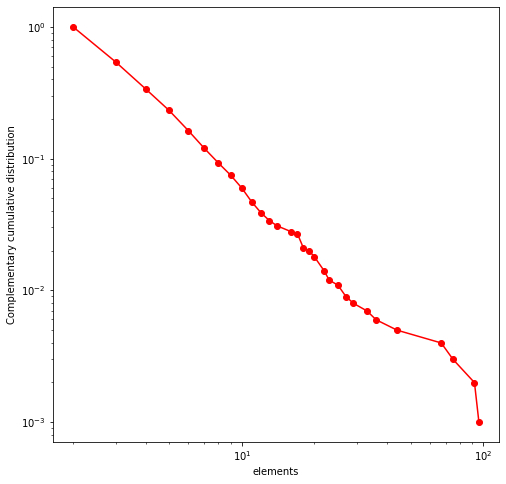

In [35]:
net = GDAM(5, 2, 2.2, 1., 0.7)
nl = net.evo(1000, 0)
net.plot_CCDF([len(i) for i in nl])

### 2. Specific snapshot

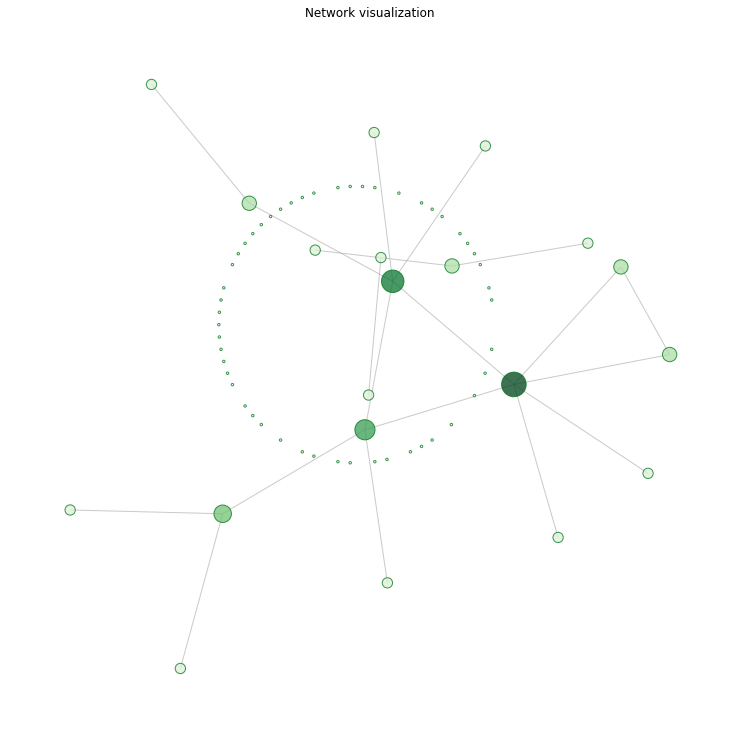

In [33]:
adj = net.snapshot(65)
net.visualize_graph(adj)
plt.savefig('git2.png',format='png')

### 3. Specific node activity

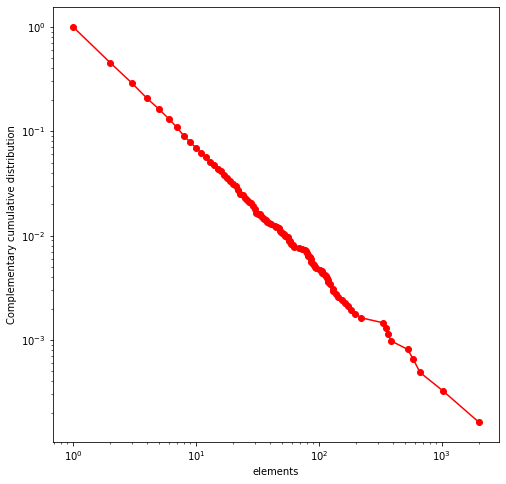

In [65]:
N_t = net.get_activenode_t(2)
net.plot_CCDF(np.diff(N_t))
plt.savefig('git3.png',format='png')

### 4. Specific link activity

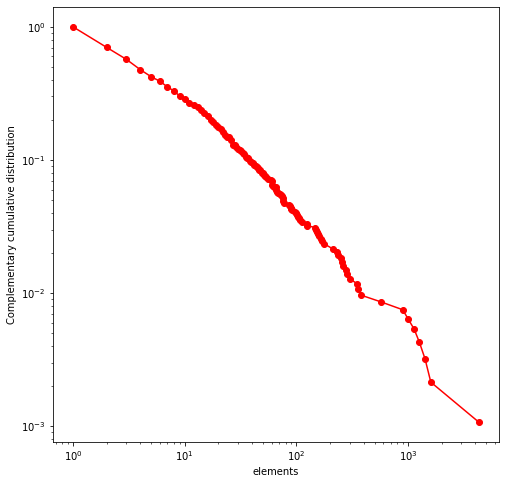

In [63]:
E_t = net.get_edge_t(0,3)
net.plot_CCDF(np.diff(E_t))
plt.savefig('git4.png',format='png')